In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("dataset.csv")

In [5]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
print(f"Dataset contains {df.shape[0]} rows")

Dataset contains 20800 rows


In [7]:
df.isnull().any()

id        False
title      True
author     True
text       True
label     False
dtype: bool

In [8]:
df = df.fillna(' ')
df.isnull().any()

id        False
title     False
author    False
text      False
label     False
dtype: bool

In [9]:
df['merged'] = df['title'] + ' ' + df['author'] + ' ' + df['text']
df = df.drop(columns=['id', 'title', 'author', 'text'])

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm

STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/georgijpetrov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


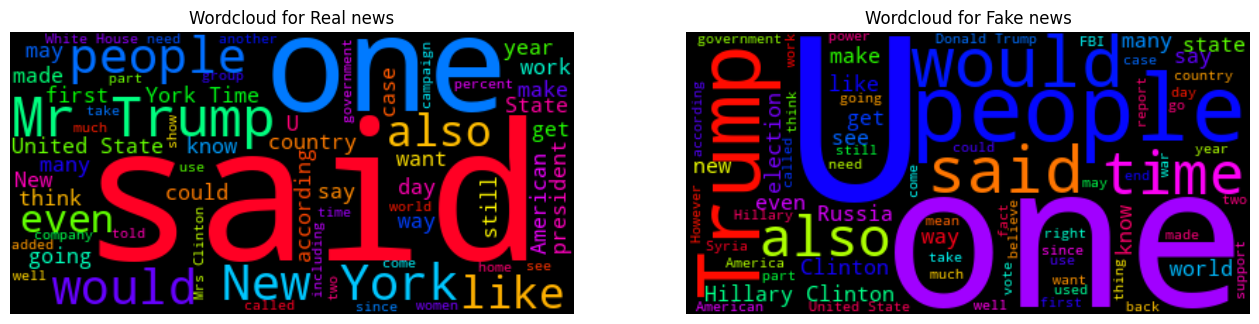

In [11]:
wc = WordCloud(
    max_words=1000, 
    
    height=600,
    width=1600,
    background_color='black',
    contour_color='black',
    
    repeat=True,
    stopwords=STOPWORDS
)

wc_real = WordCloud(min_font_size=10, colormap='hsv', stopwords=STOPWORDS).generate(' '.join(df[df['label'] == 0].merged))
wc_fake = WordCloud(min_font_size=10, colormap='hsv', stopwords=STOPWORDS).generate(' '.join(df[df['label'] == 1].merged))

fig, ax = plt.subplots(figsize=(16, 9), nrows=1, ncols=2)
for (idx, (cloud, name)) in enumerate([(wc_real, 'Real news'), (wc_fake, 'Fake news')]):
    ax[idx].imshow(cloud, interpolation= "bilinear")
    ax[idx].set_title(f"Wordcloud for {name}")
    ax[idx].axis('off')

plt.show()

In [12]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re

def clean_text(text):
    whitespace = re.compile(r"\s+")
    text = whitespace.sub(' ', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower()
    
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return ' '.join(sentence)       

df['merged'] = df['merged'].map(clean_text)
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/georgijpetrov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,label,merged
0,1,house dem aide didnt even see comeys letter ja...
1,0,flynn hillary clinton big woman campus breitba...
2,1,truth might get fire consortiumnewscom truth m...
3,1,civilians kill single us airstrike identify je...
4,1,iranian woman jail fictional unpublished story...


In [13]:
import fasttext

with open('corpus.txt', 'w') as f:
    for line in df['merged']:
        f.write(line + '\n')

fasttext_model = fasttext.train_unsupervised("corpus.txt")

Read 8M words
Number of words:  50311
Number of labels: 0
Progress: 100.0% words/sec/thread:   69135 lr:  0.000000 avg.loss:  1.975967 ETA:   0h 0m 0s


In [14]:
fasttext_model.get_nearest_neighbors('trump')

[(0.9138972163200378, 'donald'),
 (0.794519305229187, 'trumpstyle'),
 (0.7830398678779602, 'trumpclinton'),
 (0.7822917699813843, 'donaldjtrumpjr'),
 (0.7763088345527649, 'trumptrain'),
 (0.7645034790039062, 'trumpâs'),
 (0.7613914012908936, 'trumptv'),
 (0.7590810060501099, 'presidentelect'),
 (0.758475124835968, 'prodonald'),
 (0.7544806003570557, 'ivankatrump')]

In [15]:
df['embedding'] = df['merged'].apply(lambda x: fasttext_model.get_sentence_vector(x))
embedding_dim = len(df['embedding'].iloc[0]) 
embedding_cols = [f"embedding_{i}" for i in range(embedding_dim)]
embedding_df = pd.DataFrame(df['embedding'].tolist(), columns=embedding_cols, index=df.index)
df = pd.concat([df.drop(columns=['merged', 'embedding']), embedding_df], axis=1)
df.head()

,label,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
0,1,0.056409,0.077010,0.016854,-0.062378,0.025896,-0.009964,-0.115302,0.066347,0.056842,...,0.094136,0.086837,0.000216,0.061818,-0.049272,-0.036788,-0.052761,-0.026059,0.017190,0.024253
1,0,0.023564,0.085767,-0.005842,-0.027867,0.003691,-0.011408,-0.102380,0.057263,0.024757,...,0.094514,0.084675,0.010102,0.061692,-0.011981,-0.013148,-0.036954,-0.012701,-0.011379,0.014861
2,1,0.011946,0.091445,-0.001177,-0.049751,-0.033289,-0.003655,-0.125035,0.085094,0.026036,...,0.093593,0.073592,0.012152,0.049685,-0.028413,0.000383,-0.048084,-0.035319,-0.015549,0.032399
3,1,0.034656,0.118140,-0.014957,-0.067989,-0.039043,-0.032745,-0.136110,0.096286,0.007205,...,0.101675,0.071491,0.009761,0.074434,-0.065173,-0.015942,-0.041236,-0.002731,-0.031821,0.035929
4,1,0.009681,0.074021,-0.002740,-0.052725,-0.007688,-0.013288,-0.084417,0.051047,0.003495,...,0.106132,0.093287,0.014027,0.054536,-0.036712,-0.008412,-0.029687,-0.000592,0.014157,-0.000833


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'],test_size=0.25)

model_1 = LogisticRegression()
model_1.fit(x_train, y_train)
pred_1 = model_1.predict(x_test)
cr1    = classification_report(y_test, pred_1)
print(cr1)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2646
           1       0.91      0.90      0.91      2554

    accuracy                           0.91      5200
   macro avg       0.91      0.91      0.91      5200
weighted avg       0.91      0.91      0.91      5200



In [17]:
from sklearn.tree import DecisionTreeClassifier

model_2 = DecisionTreeClassifier()
model_2.fit(x_train, y_train)
pred_2 = model_2.predict(x_test)
cr2  = classification_report(y_test, pred_2)
print(cr2)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2646
           1       0.80      0.81      0.80      2554

    accuracy                           0.81      5200
   macro avg       0.81      0.81      0.81      5200
weighted avg       0.81      0.81      0.81      5200



In [18]:
from sklearn.ensemble import RandomForestClassifier

model_3 = RandomForestClassifier()
model_3.fit(x_train,y_train)
pred_3 = model_3.predict(x_test)
cr3    = classification_report(y_test,pred_3)
print(cr3)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2646
           1       0.91      0.89      0.90      2554

    accuracy                           0.91      5200
   macro avg       0.91      0.91      0.91      5200
weighted avg       0.91      0.91      0.91      5200



In [19]:
from xgboost import XGBClassifier

model_4 = XGBClassifier()
model_4.fit(x_train, y_train)
pred_4 = model_4.predict(x_test)
cr4   = classification_report(y_test,pred_4)
print(cr4)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2646
           1       0.93      0.92      0.93      2554

    accuracy                           0.93      5200
   macro avg       0.93      0.93      0.93      5200
weighted avg       0.93      0.93      0.93      5200



In [20]:
from catboost import CatBoostClassifier

model_5 = CatBoostClassifier(iterations=200)
model_5.fit(x_train,y_train)
pred_5 = model_5.predict(x_test)
cr5    = classification_report(y_test,pred_5)
print(cr5)

Learning rate set to 0.145664
0:	learn: 0.6159476	total: 69.6ms	remaining: 13.9s
1:	learn: 0.5636213	total: 77.3ms	remaining: 7.65s
2:	learn: 0.5221459	total: 83.9ms	remaining: 5.51s
3:	learn: 0.4876990	total: 89.7ms	remaining: 4.4s
4:	learn: 0.4582252	total: 95.5ms	remaining: 3.73s
5:	learn: 0.4348242	total: 102ms	remaining: 3.29s
6:	learn: 0.4158900	total: 108ms	remaining: 2.97s
7:	learn: 0.3986800	total: 115ms	remaining: 2.75s
8:	learn: 0.3824980	total: 121ms	remaining: 2.56s
9:	learn: 0.3700961	total: 128ms	remaining: 2.42s
10:	learn: 0.3594441	total: 134ms	remaining: 2.29s
11:	learn: 0.3488920	total: 140ms	remaining: 2.19s
12:	learn: 0.3396563	total: 146ms	remaining: 2.1s
13:	learn: 0.3312762	total: 152ms	remaining: 2.02s
14:	learn: 0.3235167	total: 158ms	remaining: 1.95s
15:	learn: 0.3168347	total: 164ms	remaining: 1.89s
16:	learn: 0.3088300	total: 170ms	remaining: 1.83s
17:	learn: 0.3031681	total: 176ms	remaining: 1.78s
18:	learn: 0.2979966	total: 182ms	remaining: 1.74s
19:	lear

In [ ]:
import torch
import torch.nn as nn

# I'll implement it better soon
class LSTMModel(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=100):  
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x): return torch.sigmoid(self.fc(self.lstm(x.unsqueeze(1))[0][:, -1]))

In [44]:
from torch.utils.data import DataLoader, TensorDataset

X = torch.tensor(x_train.values)
y = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
train_loader = DataLoader(TensorDataset(X, y), batch_size=128, shuffle=True)

In [45]:
import torch.optim as optim
from tqdm import tqdm

model = LSTMModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()
for epoch in tqdm(range(10), desc="Epochs", leave=True):
    model.train()
    for X_batch, y_batch in tqdm(train_loader, desc="Batches", leave=False): 
        optimizer.zero_grad()  
        loss = loss_fn(model(X_batch), y_batch)  
        loss.backward()  
        optimizer.step()
        
model.eval()

Epochs: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


LSTMModel(
  (lstm): LSTM(100, 300, batch_first=True)
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [46]:
y_pred = []

with torch.no_grad():
    X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
    y_pred = model(X_test_tensor).round().numpy().flatten()
    
cr5 = classification_report(y_test, y_pred)
print(cr5)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2646
           1       0.92      0.94      0.93      2554

    accuracy                           0.93      5200
   macro avg       0.93      0.93      0.93      5200
weighted avg       0.93      0.93      0.93      5200

